In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from lifelines import CoxPHFitter
from lifelines import KaplanMeierFitter

# Task 1:
Analyze subscriber data to predict an average customer lifetime. **Create a model that predicts the length of an expected average customer lifespan.**<br><br>
***Note***: For confidentiality reasons, I will be not be able to show the data. Hence, I have listed the data definition in detail below.

### Step 1: Data cleaning

In [2]:
# read the data
subscriber_data = pd.read_csv("Subscriber Data_Spreadsheet.csv", skiprows=[0]) #skiprows excludes reading in the first row

In [3]:
subscriber_data.dtypes

TransactionID                    object
Transaction Start Date           object
User ID                          object
Status                           object
Term Type                        object
Transaction Cancellation Date    object
Transaction Expiration Date      object
Auto Renew Enabled                 bool
Device                           object
dtype: object

**Data definition:**
<pre>
TransactionID                    Unique ID of each subscription transaction
Transaction Start Date           Start date of subscription transaction
User ID                          Unique subcriber account Id
Status                           Subscription status (active or not)
Term Type                        Subscription type (6-month or 1-year)
Transaction Cancellation Date    Date when user cancelled their subscription
Transaction Expiration Date      Subscription End Date (past) or when it will end automatically (future) if not renewed
Auto Renew Enabled               True/False
Device                           Desktop/Mobile/Tablet/Other
</pre>

In [4]:
print("# of rows and columns in data set: ", subscriber_data.shape)
print("# of Unique users: ", len(subscriber_data["User ID"].unique()))
print("# of Unique transactions: ", len(subscriber_data["TransactionID"].unique()))

# of rows and columns in data set:  (98351, 9)
# of Unique users:  92603
# of Unique transactions:  98351


**Observation:** <br>
There are 176 unique transaction IDs which contain duplicate entries across all other columns. These duplicate rows will not provide any new information. Hence, I will de-dupe these records. 

In [5]:
subscriber_fullDups = subscriber_data[subscriber_data.duplicated(subset = ['Transaction Start Date', 'User ID', 'Status',
                                                                      'Term Type', 'Auto Renew Enabled', 
                                                                      'Transaction Cancellation Date', 'Device', 
                                                                      'Transaction Expiration Date'] , keep = False)]
# this code shows that there are 176 transaction entries containing duplicate entries under all columns expect TransactionID

In [6]:
# delete the duplicate entries and keep just first occurence
dedupe_1 = subscriber_data.drop_duplicates(['Transaction Start Date', 'User ID', 'Status',
                                                                      'Term Type', 'Auto Renew Enabled', 
                                                                      'Transaction Cancellation Date', 'Device', 
                                                                      'Transaction Expiration Date'], keep = 'first')
print("Shape after first de-duplication: ", dedupe_1.shape)
print("# unique users: ", len(dedupe_1["User ID"].unique()))

Shape after first de-duplication:  (98251, 9)
# unique users:  92603


**Observation:** <br>
Further I noted that there are 146 transaction IDs which contain same information under the combination of columns - ['Transaction Start Date', 'User ID', 'Term Type', 'Transaction Expiration Date']. Duplication in these four columns may mean that they represent the exact same transaction/subscription. <br><br>
*Example*: There are two rows with same information in ['Transaction Start Date', 'User ID', 'Term Type', 'Transaction Expiration Date'] columns. The only difference is in 'Auto Renew Enabled' (values given - True/False). This might have been an issue while recording the data. <br><br>
*Solution*: To de-dupe them, I will keep the first occurence and delete the rest of the duplicates. (Note: The decision to keep the first occurence is for the sake of simplicity. More advanced data cleaning steps can be applied in future like imputing the median value for ['Auto Renew Enabled', 'Device'] columns.

In [7]:
subscriber_partialDups = dedupe_1[dedupe_1.duplicated(['Transaction Start Date', 'User ID', 'Term Type', 
                                                      'Transaction Expiration Date'], keep = False)]

In [8]:
dedupe_2 = dedupe_1.drop_duplicates(['Transaction Start Date', 'User ID', 'Term Type', 
                                  'Transaction Expiration Date'], keep = 'first')
print("Shape after final de-duplication: ", dedupe_2.shape)
print("# unique users: ",len(dedupe_2["User ID"].unique()))
# removed total 173 rows with duplicate/questionable entries

Shape after final de-duplication:  (98178, 9)
# unique users:  92603


**Observation:** <br>
1. There are 87,684 users with only single transactions in the data set. <br><br>
2. There are 4,919 users with multiple transactions, with total transaction records for them being 10,494. This group consists of users who have performed multiple actions such as upgrading/cancelling then activating their subscriptions. <br><br>
3. *Note:* I will concentrate on the 87,684 users in the below analysis because single transaction users form the larger part of the data. Also, users with multiple transactions will need separate data pre-processing for calculating accurate duration of their subscriptions (as listed at the end of the notebook). 

In [9]:
# separating single transaction users
user_groups = pd.DataFrame(dedupe_2.groupby(['User ID'])['TransactionID'].count()).reset_index()
unique_userIDs = user_groups.loc[user_groups.TransactionID == 1]
unique_userIDs.drop("TransactionID", axis = 1, inplace = True)

# separating multiple transaction users
multiple_userIDs = user_groups.loc[user_groups.TransactionID > 1]
multiple_userIDs.drop("TransactionID", axis = 1, inplace = True)
print("# users with unique transaction records: ", unique_userIDs.shape)
print("# users with multiple transaction records: ", len(multiple_userIDs))

# users with unique transaction records:  (87684, 1)
# users with multiple transaction records:  4919


**I will use following data (containing unique transactions for each user account) for further analysis and modeling average customer life span**

In [10]:
unique_user_trans = pd.merge(unique_userIDs, dedupe_2, how='inner', on=['User ID'])

In [11]:
multiple_user_trans = pd.merge(multiple_userIDs, dedupe_2, how='inner', on=['User ID'])
print("# rows and columns: ", multiple_user_trans.shape)

# keeping this part out for now
# needs further processing to calculate accurate subscription duration, to be used in survival modeling.

# rows and columns:  (10494, 9)


### Step 2: Data Pre-processing

Calculation of averge customer lifetime can be done using 'survival analysis' where:<br>
1. Event: Customer churned (I will create a new column with this information)
2. Time line: The time from the beginning of an observation period (subsription start time) to its end (subscription end time or today's date, which signifies end of study)
3. Time of event Occurrence (T): Random time at which the event may occur
4. Right-Censoring: There are users who haven’t encountered the event (subscription termination) during the observation time. This makes the data right-censored.
<br>

*Reference:*

[More on types of censoring](https://blog.minitab.com/blog/michelle-paret/the-difference-between-right-left-and-interval-censored-data)

In [12]:
# convert the date columns from string to datetime, for further manipulation

unique_user_trans['Transaction Start Date'] = pd.to_datetime(unique_user_trans['Transaction Start Date'])
unique_user_trans['Transaction Cancellation Date'] = pd.to_datetime(unique_user_trans['Transaction Cancellation Date'])
unique_user_trans['Transaction Expiration Date'] = pd.to_datetime(unique_user_trans['Transaction Expiration Date'])

In [13]:
unique_user_trans["Status"].value_counts()

active             41371
expired            29344
payment failure    10427
cancelled           6514
won't renew           28
Name: Status, dtype: int64

#### Assumptions related to the data:
1. For transaction status = 'Payment Failure', if user has not initiated new transaction after that, I will consider the expiration date as the last date of user's activity and consider the user churned. <br><br>
2. For active users whose transaction expiration date is in the past (before 3rd July 2020), I will assume the subscription is still active. Hence, for calculating length of their subscription, I will consider the difference between today's date (3rd July 2020) and corresponding transaction start date. <br><br>
3. For [Expired, Payment Failure and Won't renew] transactions, use the expiration date as time of event. <br>This is based on my assuption/intuition as the data file said *Transaction Expiration Date means the End Date of subscription transaction (past) or when it is set to end automatically (future) if not renewed*.

In [14]:
# following function calculates duration/tenure of subscription in DAYS. 

def calculate_days(row):
    """
    Logic for choosing subscription end date:
    
    1. Cancelled transactions :: use the cancellation date as time of event
    2. [Expired, Payment Failure and Won't renew] transactions :: use the expiration date as time of event
    3. Active transactions :: Event has not occured. So subcription duration is calculated till today's date. 

    """
    
    if row['Status'] == "cancelled":
        val = (row['Transaction Cancellation Date'] - row['Transaction Start Date'])/np.timedelta64(1, 'D')
    
    elif row['Status'] == "expired" or row['Status'] == "payment failure" or row['Status'] == "won't renew":
        val = (row['Transaction Expiration Date'] - row['Transaction Start Date'])/np.timedelta64(1, 'D')
    
    elif row['Status'] == "active":
        val = (pd.to_datetime('07-03-2020') - row['Transaction Start Date'])/np.timedelta64(1, 'D')
    
    else:
        val = 0
        
    return int(val)

# new column with tenure in days
unique_user_trans['Tenure'] = unique_user_trans.apply(calculate_days, axis=1)

# all users who are not active have been labelled as churned. Note - decision based on intuition. 
# In reality, business input would be helpful here
unique_user_trans['Churn'] = np.where(unique_user_trans['Status']=='active', 0, 1)

In [15]:
unique_user_trans.dtypes
# dataframe with 2 new columns 'Tenure', 'Churn' is ready for use in modeling

User ID                                  object
TransactionID                            object
Transaction Start Date           datetime64[ns]
Status                                   object
Term Type                                object
Transaction Cancellation Date    datetime64[ns]
Transaction Expiration Date      datetime64[ns]
Auto Renew Enabled                         bool
Device                                   object
Tenure                                    int64
Churn                                     int32
dtype: object

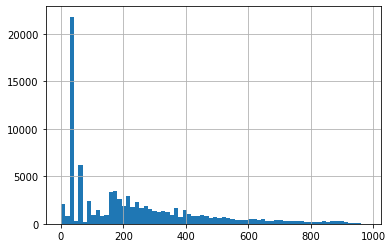

In [16]:
unique_user_trans["Tenure"].hist(bins=70)

### Step 3: Data Exploration/Preliminary Analysis

#### Kaplan Myer Estimate (Non-Parametric Method)

I will fit KM Estimate to:
1. Get an aggregated view of how long someone is going to be a customer typically. 
2. Compare the overall survival rates of monthly and yearly subscriber cohorts.
3. Take a simplistic approach to model only the survival time (without any other impacting variables), which does not assume any underlying distribution of survival times. 
<br><br>
Note: Kaplan-Meier curve can be used when every user can have only a single “birth” (subscription activation) and a single “death” (regardless of whether it is observed or not) event. Since the data set I am using only has single record for each user, I will go ahead and fit KM curve below.

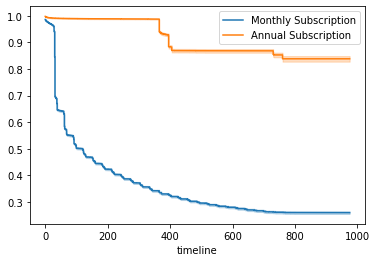

In [17]:
# create a kmf object
kmf = KaplanMeierFitter() 

T = unique_user_trans['Tenure']   
E = unique_user_trans['Churn']

groups = unique_user_trans['Term Type']   
i1 = (groups == 'Monthly')      ## group i1 , having the pandas series  for the 1st cohort
i2 = (groups == 'Annual')     ## group i2 , having the pandas series  for the 2nd cohort

# fit the model for 1st cohort
kmf.fit(T[i1], E[i1], label='Monthly Subscription')
a1 = kmf.plot()

# fit the model for 2nd cohort
kmf.fit(T[i2], E[i2], label='Annual Subscription')
kmf.plot(ax=a1)

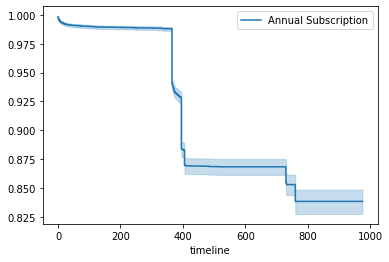

In [18]:
# get a better look at annual subscribers
# Note: the flat lines correspond to 365 days (a year), which is the length of annual subscription.
# Hence, there is no decrease in survival rate during that time

kmf.fit(T[i2], E[i2], label='Annual Subscription')
a2 = kmf.plot()

**Observations:**
1. At any point t across the timeline, the survival probability of annual subscribers is more than monthly subscribers. <br><br>
2. For monthly subscribers, the survival probability is decreasing with high rate during initial 200 days (~6 months) and it gets relatively better after that. <br><br>
3. For annual subscribers, the rate of decrease in survival rate is dramatic after 1st year compared to the decrease after 2nd year. Indicating that there is a high probability of people churning after 1st year and the rate decreases after 2nd year. <br><br>
4. **Business Recommendation**: For the cohort who maintain a monthly subscription, efforts should be made to retain them in initial 6 volatile months. And for the annual subscribers, effort should be made to retain them towards the end of their 1st Annual membership.

### Step 4: Modeling

### Motivation behind choice of the model, along with statistical reasoning and assumptions:
#### Answer 1:
Model Selection (Non-Parametric vs Semi-Parametric vs Parametric):
1. Non-parametric models are too simplistic. They are not efficient at predictions into future at user-level. Hence, I used them only for exploration <br><br>
2. Parametric models are best when underlying distribution is already known. An underlying distribution can be known either by business sense (e.g. if user churn probability gets lower with longer subscription lengths, then it follows a Lomax distribution. On the contrary if it increases, then it follows Weibull distribution) or it can be known using goodnes of fit test which requires more data.<br>
Here, the underlying distribution could be log-normal/Weibull/exponential/log-logistic etc., in which case a maximum likelihood approach for estimating corresponding parameters will need to be used. However, since I do not already know the data distribution and I am not willing to make an assumption, I will de-prioritize parametric models <br><br>
3. Semi-parametric models like Cox Proportional Hazards fit survival models without knowing (or assuming) the underlying distribution. Hence, I will choose Cox PH model. <br><br>
**CoxPH Model Assumptions:**<br>
-- There is constant relationship between dependent and independent variables.<br>
-- The Hazard Ratio (rate of experiencing event at given time) of two subjects remains the same at all times.<br>
Note: I have listed other simplifying assumptions around data in above sections.

### Stochastic properties of the dataset considered when developing the model and model characteristics/hyper-parameters to account for those:
#### Answer 2:
Stochastic properties:
1. A single individual can have multiple actions on the same account. Hence they show up in the dataset more than once. Such records are present in the 'multiple_user_trans' dataframe above. Solution - The clustering characteristic of CoxPH can solve this. <br><br>
2. The "Cancelled transactions" have same subscription start and expiry dates. This introduces zeros in 'Tenure' when I calculate the duration of these user's memberships (Note: these users have no other account status such as active/upgrade; but only cancellations). Solution - CoxPH model can handle tenure = 0 at t=0 (beginning of study). No other parametric models, such as Weibull/Log-Normal can directly handle this case. <br><br>
3. There does not seem to be high-correlation between variables. Also the number of variables is less. If either of these were true, then they would need to be handled using the 'penalizer' hyper parameter of CoxPH

*Reference*:

[Very good discussion on model selection](https://stats.stackexchange.com/questions/64739/in-survival-analysis-why-do-we-use-semi-parametric-models-cox-proportional-haz)

### Regarding the dimensionality of the data:
#### Answer 3:
Currently, the dimensionality of the given data is small with only 3 other covariates in addition to Tenure and Churn. However, when anlaysis is to be performed with high dimensionality data (large number of covariates) then:
1. Feature selection methods should be used, especially to get rid of redundant and highly correlated variables
2. Feature extraction methods should be used, using say random survival forests
3. When categorical data is present in addition to numeric data and the levels in categorical data are high then appropriate level-reduction techniques should be employed as opposed to using One Hot Encoding.
4. If the # of rows is very huge, stratified sampling technique should be used to sample both censored and uncensored data points, proportional to their population distribution
5. Use regularization technique, when using regression models such as CoxPH to minimize coefficients of ineffective variables and select impactful features

### Potential sources of statistical bias in the data that could introduce error into your model and their treatment through choice of model or re-collection of data:
#### Answer 4:
A statistical bias occurs when a statistic is calculated in such a way that it is systematically different from the population parameter being estimated. <br>
Potential sources and solutions:
1. *Estimator bias:* Assuming a particular distribution beforehand and estimating parameters wrongly using parametric models. Example: For a business with churn increasing per day, if the distribution is assumed to be lomax (which actually represents churn probability getting lower with longer subscriptions) then it will result in statistical bias. <br>
*Solution* - Instead of assuming, apply semi-parametric models <br><br>
2. *Selection bias* - If certain users are more likely to be selected (such as uncensored vs censored users) or if we choose not to include the censored data at all, then it is highly likely that our life span estimates would be highly biased and under-estimated. <br>
*Solution* - Apply stratified sampling or equal proportion sampling techniques and make sure all cohorts present in population data are represented in the sample


*Reference:*

[Statistical Bias Wiki Definition](https://en.wikipedia.org/wiki/Bias_(statistics))

### Confidence score for the results - could be in-built or custom developed metric(s) to determine how trustworthy are the predictions for mean subscriber lifetime:
#### Answer 5:

I would develop a confidence score which would be a weighted average of:
1. Lifetime-only metric - how many standard deviations is the predicted mean of certain subscriber's lifetime from the overall mean of historical lifetime of cohort. (KEY: this metric should be low)
2. Independent variables metric - how many standard deviations is the value of independent variables for certain subscriber as compared to the overall cohort statistics (KEY: this metric should be low)
3. Missing data metric - ratio of number of missing columns and total columns for the concerned customer (KEY: this metric should be low)<br>
Thus,<br>
Confidence score = Inverse of (a.Lifetime-only metric + b.Independent variables metric + c.Missing data metric)<br>
where a,b,c are weights<br>
Inverse is required because the equation is minimizing for optimal cases. To represent confidence closer to 100, we will need to inverse the equation

### State-space representation of the model:
#### Answer 6:
I have not used a neural network for modeling. As per my knowledge, state space representation would be more applicable for neural networks as opposed to regression or exponentials.

### Considerations and optimizations for model scalability in prodution:
#### Answer 7:
For building a practical predictor:
1. *Data Structure optimizations* - For the assessment purposes, I have heavily relied on dataframe and their operations which can cause bottlenecks. Example the function to calculate tenure days takes a few seconds currently. On scaling, this transformation can create a bottleneck. I will have to choose faster and efficient data structures such as arrays <br><br>
2. *Model Complexity* - I would start with simpler models. Complex models like deep neural networds govern computation cost complexity. So I would critically assess if using a deep NN gives me a significant lift in predictions or not. If not, I would concentrate on optimizing the hyperparameters of simpler survival models for better predictions. <br><br>
3. *One-off training* - Models don’t necessarily need to be continuously trained. I would need to optimize on robust, trackable model performance metrics such that they can be monitored and model be trained only when performance signficantly decreases.<br><br>
4. *Batch vs. Real-time Prediction* - Real-time predictions have data-load, cost and infrastructure implications. I would make my model a batch model as customer avg lifetime need not output results in real-time <br><br>
5. *Sampling data* - For training the model, samples from coherent clusters can be taken instead of feeding the whole data if the population data is humungous.

### Model tuning in case of increase of errors in model predictions:
#### Answer 8:
To initially build a model which can adapt to changes without having to completely re-model requires real-time online machine learning models. As mentioned in Asnwer 7, these real-time models have cost implications. If the goal is to keep the overall process efficient within "limited resource constraints", I would rather take following approach:

1. *Calculate Model Drift* - Drift means model’s predictive performance degrades over time due to changes in inputs, which violate the model’s assumptions. It can be measured in terms of the accuracy, recall metrics (Note: to calculate accuracy/recall, the true 'y' values might not be instantaneously available at the time predictions are generated. In this case, the drift will be lagged in time, say by a few days or months). <br><br>
2. *Employ Feature Inspection* - Model performance is expected to degrade if the incoming data deviate significantly as compared to the training data distributions. This might be due to outliers or one-off changes in trends.<br>
2a. I would monitor each feature in terms of distribution, NULLs, outliers. And treat them before sending into the model for prediction. <br>
2b. Feature correlations can be monitored as certain models are based on assumptions that feature need to be uncorrelated<br>
2c. Business sense can be applied, in the sense that if the changing trend in features is one-off and not expected then scaling and transformation techniques can be used. Additionally, model assumptions should be checked which use input features <br> 
2d. Check the distribution of target variable<br><br>
3. *Minimized number of complete model retrainings* - Both above steps will minimize the number of complete model retrainings. However, complete model retrainings are required for improving predictive performance, in case of addition of new data sources or new feature engineering or hyperparameter tuning for changed trends in input features.

In [19]:
unique_user_modelDF = unique_user_trans[["Term Type", "Auto Renew Enabled", "Device", "Tenure","Churn"]]
unique_user_modelDF.dtypes

Term Type             object
Auto Renew Enabled      bool
Device                object
Tenure                 int64
Churn                  int32
dtype: object

In [20]:
df_dummy = pd.get_dummies(unique_user_modelDF, drop_first=True)
df_dummy["Auto Renew Enabled"] = df_dummy["Auto Renew Enabled"].astype(int)
df_dummy.dtypes

Auto Renew Enabled    int32
Tenure                int64
Churn                 int32
Term Type_Monthly     uint8
Device_external       uint8
Device_mobile         uint8
Device_other          uint8
Device_tablet         uint8
dtype: object

In [21]:
corr = df_dummy.corr()
corr.style.background_gradient(cmap='coolwarm')
# there is no strong correlation present (which will need to be treated)

,Auto Renew Enabled,Tenure,Churn,Term Type_Monthly,Device_external,Device_mobile,Device_other,Device_tablet
Auto Renew Enabled,1.000000,0.000650,-0.034302,-0.009959,-0.016950,0.005023,0.001480,0.000801
Tenure,0.000650,1.000000,-0.659394,-0.403603,-0.068065,-0.027643,0.019593,0.058130
Churn,-0.034302,-0.659394,1.000000,0.472387,0.120510,-0.045234,-0.012857,-0.035840
Term Type_Monthly,-0.009959,-0.403603,0.472387,1.000000,0.027568,0.062320,-0.039294,-0.046971
Device_external,-0.016950,-0.068065,0.120510,0.027568,1.000000,-0.142197,-0.006792,-0.038318
Device_mobile,0.005023,-0.027643,-0.045234,0.062320,-0.142197,1.000000,-0.018400,-0.103805
Device_other,0.001480,0.019593,-0.012857,-0.039294,-0.006792,-0.018400,1.000000,-0.004958
Device_tablet,0.000801,0.058130,-0.035840,-0.046971,-0.038318,-0.103805,-0.004958,1.000000


### Step 4a: Train the model

In [22]:
cph = CoxPHFitter().fit(df_dummy, 'Tenure', 'Churn')
#cph.check_assumptions(df_dummy, p_value_threshold=0.05)
cph.print_summary()

**Observation**:
1. The Concordance index is 0.67 which indicates that this is a good basic model for average life span prediction. (Usually, the real-world fitted models have a concordance index between 0.55 and 0.7 which is due to the noise present in the data).
2. All the variables are significant except 'Device_other'

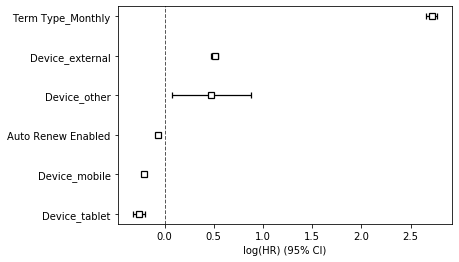

In [23]:
cph.plot()

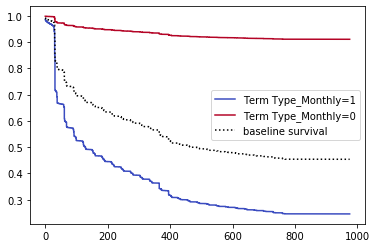

In [24]:
cph.plot_covariate_groups('Term Type_Monthly', [1,0], cmap='coolwarm')

### Step 4b: Test the model

Predicted median customer life span (in days)
5    123.0
6     99.0
7    184.0
8    219.0
9    219.0
Name: 0.5, dtype: float64


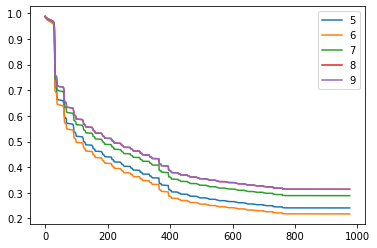

In [25]:
tr_rows = df_dummy.iloc[5:10] #randomly select candidates for prediction
tr_rows

print("Predicted median customer life span (in days)")
print(cph.predict_median(tr_rows))

# Predict the survival curve. Customers can be identified with the numbers mentioned against each curve.
cph.predict_survival_function(tr_rows).plot()

In [26]:
cph.confidence_intervals_

,95% lower-bound,95% upper-bound
Auto Renew Enabled,-0.087930,-0.050058
Term Type_Monthly,2.661461,2.769745
Device_external,0.475968,0.546528
Device_mobile,-0.226630,-0.184202
Device_other,0.075123,0.876137
Device_tablet,-0.322151,-0.196410


### Extra:

In [27]:
# trying parametric models

df_dummy["Tenure"] = np.where(df_dummy['Tenure']==0, 0.001, df_dummy['Tenure'])

from lifelines import LogLogisticAFTFitter, WeibullAFTFitter, LogNormalAFTFitter
from lifelines.datasets import load_rossi

llf = LogLogisticAFTFitter().fit(df_dummy, 'Tenure', 'Churn')
lnf = LogNormalAFTFitter().fit(df_dummy, 'Tenure', 'Churn')
wf = WeibullAFTFitter().fit(df_dummy, 'Tenure', 'Churn')

print(llf.log_likelihood_)  # slightly the best model.
print(lnf.log_likelihood_)  
print(wf.log_likelihood_)  

-300875.01540795644
-307409.3756270975
-303221.8452398905


#### Future Modeling Improvements:

As the next machine learning approach, I would use random survival forest (RSF) for assessing the increase in prediction accuracy and to avoid the proportional constraint of the Cox proportional hazards model. Random Survival Forest model can be implemented using scikit_survival package

# Task 2: 

One of the key challenges in subscription businesses is managing subscriber churn. As a solution it is imperative to identify patterns in user data which will help keep them subscribed longer. I have listed my thoughts below on **reframing this business problem as a data science problem and proposed solutions from an implementations perspective**. <br>
Assuming the data consistis of both active and expired memberships with following data points:
1. Date of user joining
2. Subscription plan and type (annual or monthly)
3. Which article or landing page they converted off of
4. If and when they cancelled
5. What content they were engaging with
6. Email addresses and locations

#### Question 1: 
Identify patterns in user data to keep them subscribed longer.
#### Answer 1: 
1. *Recommendation engines*: I would employ content-based filtering or collaborative-filtering based on the available data. <br>
1a. *Content-based filtering* will recommend a new content based on user's preferred content. Approach needs more user preference data in order to incorporate best match. <br>
1b. *Collaborative filtering* will find users with similar content preferences and recommend new reading content to a user based on popularity with neighbourhood group. Approach needs large dataset with active users and their reading preferences <br><br>
2. *Behavioral customer segment*: I would employ clustering techniques on behavioral and demographics data such as locations, amount of product usage, source of conversion (landing page/article) etc. to find segments especially at-risk of churning and study their behavioral characteristics<br><br>
3. *Cross-sell/Up-sell/Repeat purchase*: I would employ Market Basket Analysis to find associations between related content and recommend to user. Additionally, targeted marketing through recency-frequency-monetary analysis will help engage at-risk customers with appropriate offers.

#### Question 2: 
How can different types of churns be categorized (qualitatively)? Which ones can be addressed, and which ones cannot?
#### Answer 2: 
Different types of reasons of churn are:
1. *Contractual Churn* - when users decide not to continue/renew with their expired subscriptions. <br><br>
2. *Voluntary Churn* - when users cancel their existing service. This can be further divided into:<br>
2a. *Product Usability Churn* - when users fail to encounter the “aha” moment in initial engagement days. “aha” moment is the instant when users understand the value of product <br>
2b. *High Price Churn* - when users find lower prices at competitors <br><br>
3. *Payment Failure Churn* - when users experience friction transacting with the product, which eventually discourages them from further engagement<br><br>
4. *Unavoidable churn*: While all above are avoidable churn, some unavoidable churn can be: <br><br>
4a. *Missing Product Feature Churn* [Addressable] - when users leave because they seek a particular product functionality, not developed in our product yet. Note: This churn can be addressed by aligining product development road map with customer needs <br>
4b. *Involuntary churn* [Unaddressable] - when users (organizations) go out of business or individual users can't pay for subscriptions due to financial hardships.

*Reference:*

[Facebook's aha moment and how to find it](https://mode.com/blog/facebook-aha-moment-simpler-than-you-think/)

#### Question 3:
How would you go about identifying and measuring these categories analytically, in your dataset?
#### Answer 3: 
1. *Contractual Churn* - **Identify**: # of users not renewing monthly (or annual) subscriptions. **Measure**: Track contract renewal rate.<br><br> 
2. Voluntary Churn - <br>
2a. Product Usability Churn - **Identify**: find set of actions such that majority of users who took the action were retained. Example - For a travel booking app, users adding in a payment method such as credit card is an action that high proportion of the retained group would take. **Measure**: Count # of new users who took the "aha" action.<br>
2b. High Price Churn - **Identify**: User exit-survey. **Measure**: # Users who gave the reason of leaving as High product price. And calculate Product ROI for customers and advertise the cost/time save<br><br>
3. Payment Failure Churn - **Identify**: trasaction processing status **Measure**: # transactions with failed status and reason as 'payment failure'